In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

#torch.manual_seed(111)

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


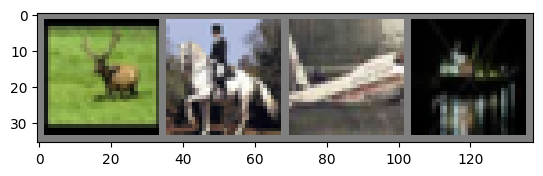

deer  horse plane ship 


In [ ]:
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)                             # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [4]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
      epoch_loss = []
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = net(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      # print statistics
      running_loss += loss.item()
      epoch_loss.append(loss.item())
      if (i + 1) % 2000 == 0:    # print every 2000 mini-batches
          print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
          running_loss = 0.0
  print(f"Mean epoch loss: {np.mean(epoch_loss)}")

print('Finished Training')

[1,  2000] loss: 2.219
[1,  4000] loss: 1.883
[1,  6000] loss: 1.654
[1,  8000] loss: 1.561
[1, 10000] loss: 1.506
[1, 12000] loss: 1.430
Mean epoch loss: 2.060713052749634
[2,  2000] loss: 1.391
[2,  4000] loss: 1.358
[2,  6000] loss: 1.327
[2,  8000] loss: 1.305
[2, 10000] loss: 1.274
[2, 12000] loss: 1.276
Mean epoch loss: 0.6642045378684998
Finished Training


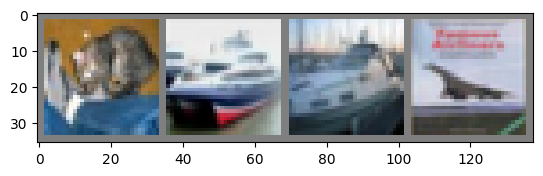

GroundTruth:  cat   ship  ship  plane


In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))


Predicted:  dog   dog   deer  horse


In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, label = images.to(device), labels.to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 56 %


In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 63.0 %
Accuracy for class: car   is 59.8 %
Accuracy for class: bird  is 24.4 %
Accuracy for class: cat   is 40.1 %
Accuracy for class: deer  is 47.1 %
Accuracy for class: dog   is 51.1 %
Accuracy for class: frog  is 63.6 %
Accuracy for class: horse is 70.8 %
Accuracy for class: ship  is 71.7 %
Accuracy for class: truck is 72.0 %


## Exercise 0
Find the correct mean and std of CIFAR10 dataset to normalize data correctly, i.e., to have data with mean 0 and std 1.

In [ ]:
def get_mean_std(trainLoader):
    imgs = None
    for batch in trainLoader:
        image_batch = batch[0]
        if imgs is None:
            imgs = image_batch.cpu()
        else:
            imgs = torch.cat([imgs, image_batch.cpu()], dim=0)
    imgs = imgs.numpy()

    # calculate mean over each channel (r,g,b)
    mean_r = imgs[:,0,:,:].mean()
    mean_g = imgs[:,1,:,:].mean()
    mean_b = imgs[:,2,:,:].mean()
    print(mean_r,mean_g,mean_b)

    # calculate std over each channel (r,g,b)
    std_r = imgs[:,0,:,:].std()
    std_g = imgs[:,1,:,:].std()
    std_b = imgs[:,2,:,:].std()
    print(std_r,std_g,std_b)

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor()])

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
get_mean_std(trainloader)

0.4914001 0.48215786 0.44653177
0.24703239 0.24348521 0.2615877


In [8]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4913998, 0.48215738, 0.44653124), (0.24703224, 0.2434851, 0.26158783))])

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:05<00:00, 30.9MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
get_mean_std(trainloader)

-4.2363047e-07 4.2770134e-06 -1.2038541e-06
0.9999998 1.0000013 0.99999994


### Exercise 1
Try to use a scheduler for the learning rate (https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate).

- What are the differences?
- Does it improves the training convergence/test accuracy?

In [23]:
def train(epochs, trainloader, net, optimizer, criterion, scheduler=None):
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if (i + 1) % 500 == 0:    # print every 500 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 500:.3f}')
                running_loss = 0.0
        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(running_loss)
            else:
                scheduler.step()
    print('Finished Training')

In [6]:
def test(testloader, net):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, label = images.to(device), labels.to(device)
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted.cpu() == labels).sum().item()

    print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

In [7]:
def test_class(testloader, net):
    # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    # again no gradients needed
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1


    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

In [ ]:
net = Net().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

train(10, trainloader, net, optimizer, criterion)
test(testloader, net)
test_class(testloader, net)


[1,   500] loss: 2.281
[2,   500] loss: 1.930
[3,   500] loss: 1.687
[4,   500] loss: 1.552
[5,   500] loss: 1.464
[6,   500] loss: 1.388
[7,   500] loss: 1.325
[8,   500] loss: 1.276
[9,   500] loss: 1.221
[10,   500] loss: 1.178
Finished Training
Accuracy of the network on the 10000 test images: 57 %
Accuracy for class: plane is 63.5 %
Accuracy for class: car   is 77.3 %
Accuracy for class: bird  is 49.2 %
Accuracy for class: cat   is 23.3 %
Accuracy for class: deer  is 44.7 %
Accuracy for class: dog   is 60.2 %
Accuracy for class: frog  is 59.4 %
Accuracy for class: horse is 71.7 %
Accuracy for class: ship  is 61.5 %
Accuracy for class: truck is 61.7 %


In [ ]:
from torch.optim.lr_scheduler import MultiStepLR

net = Net().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
scheduler = MultiStepLR(optimizer, milestones=[1, 7], gamma=0.1)

train(10, trainloader, net, optimizer, criterion, scheduler)
test(testloader, net)
test_class(testloader, net)

[1,   500] loss: 1.879
[2,   500] loss: 1.338
[3,   500] loss: 1.273
[4,   500] loss: 1.235
[5,   500] loss: 1.199
[6,   500] loss: 1.165
[7,   500] loss: 1.132
[8,   500] loss: 1.083
[9,   500] loss: 1.075
[10,   500] loss: 1.069
Finished Training
Accuracy of the network on the 10000 test images: 59 %
Accuracy for class: plane is 68.9 %
Accuracy for class: car   is 73.1 %
Accuracy for class: bird  is 44.4 %
Accuracy for class: cat   is 39.7 %
Accuracy for class: deer  is 49.0 %
Accuracy for class: dog   is 47.7 %
Accuracy for class: frog  is 74.9 %
Accuracy for class: horse is 67.2 %
Accuracy for class: ship  is 69.9 %
Accuracy for class: truck is 63.9 %


In [ ]:
net = Net().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = MultiStepLR(optimizer, milestones=[1, 5], gamma=0.1)

train(10, trainloader, net, optimizer, criterion, scheduler)
test(testloader, net)
test_class(testloader, net)

[1,   500] loss: 2.045
[2,   500] loss: 1.770
[3,   500] loss: 1.638
[4,   500] loss: 1.550
[5,   500] loss: 1.475
[6,   500] loss: 1.379
[7,   500] loss: 1.353
[8,   500] loss: 1.343
[9,   500] loss: 1.336
[10,   500] loss: 1.327
Finished Training
Accuracy of the network on the 10000 test images: 50 %
Accuracy for class: plane is 52.7 %
Accuracy for class: car   is 68.4 %
Accuracy for class: bird  is 23.7 %
Accuracy for class: cat   is 33.3 %
Accuracy for class: deer  is 42.4 %
Accuracy for class: dog   is 46.2 %
Accuracy for class: frog  is 62.0 %
Accuracy for class: horse is 58.0 %
Accuracy for class: ship  is 60.3 %
Accuracy for class: truck is 53.3 %


In [ ]:
net = Net().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

train(50, trainloader, net, optimizer, criterion)
test(testloader, net)
test_class(testloader, net)

[1,   500] loss: 2.300
[2,   500] loss: 2.105
[3,   500] loss: 1.765
[4,   500] loss: 1.539
[5,   500] loss: 1.446
[6,   500] loss: 1.373
[7,   500] loss: 1.325
[8,   500] loss: 1.275
[9,   500] loss: 1.245
[10,   500] loss: 1.200
[11,   500] loss: 1.164
[12,   500] loss: 1.134
[13,   500] loss: 1.111
[14,   500] loss: 1.083
[15,   500] loss: 1.060
[16,   500] loss: 1.029
[17,   500] loss: 1.014
[18,   500] loss: 0.987
[19,   500] loss: 0.973
[20,   500] loss: 0.945
[21,   500] loss: 0.933
[22,   500] loss: 0.922
[23,   500] loss: 0.902
[24,   500] loss: 0.879
[25,   500] loss: 0.866
[26,   500] loss: 0.854
[27,   500] loss: 0.829
[28,   500] loss: 0.822
[29,   500] loss: 0.808
[30,   500] loss: 0.790
[31,   500] loss: 0.779
[32,   500] loss: 0.763
[33,   500] loss: 0.743
[34,   500] loss: 0.731
[35,   500] loss: 0.719
[36,   500] loss: 0.699
[37,   500] loss: 0.690
[38,   500] loss: 0.678
[39,   500] loss: 0.672
[40,   500] loss: 0.653
[41,   500] loss: 0.645
[42,   500] loss: 0.630
[

In [ ]:
net = Net().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=0)

train(50, trainloader, net, optimizer, criterion, scheduler)
test(testloader, net)
test_class(testloader, net)

[1,   500] loss: 2.035
[2,   500] loss: 1.959
[3,   500] loss: 1.761
[4,   500] loss: 1.643
[5,   500] loss: 1.570
[6,   500] loss: 1.508
[7,   500] loss: 1.463
[8,   500] loss: 1.420
[9,   500] loss: 1.362
[10,   500] loss: 1.334
[11,   500] loss: 1.279
[12,   500] loss: 1.235
[13,   500] loss: 1.203
[14,   500] loss: 1.178
[15,   500] loss: 1.140
[16,   500] loss: 1.015
[17,   500] loss: 0.979
[18,   500] loss: 0.961
[19,   500] loss: 0.960
[20,   500] loss: 0.946
[21,   500] loss: 0.936
[22,   500] loss: 0.928
[23,   500] loss: 0.927
[24,   500] loss: 0.910
[25,   500] loss: 0.893
[26,   500] loss: 0.895
[27,   500] loss: 0.891
[28,   500] loss: 0.882
[29,   500] loss: 0.888
[30,   500] loss: 0.882
[31,   500] loss: 0.887
[32,   500] loss: 0.876
[33,   500] loss: 0.878
[34,   500] loss: 0.886
[35,   500] loss: 0.884
[36,   500] loss: 0.888
[37,   500] loss: 0.885
[38,   500] loss: 0.887
[39,   500] loss: 0.880
[40,   500] loss: 0.881
[41,   500] loss: 0.882
[42,   500] loss: 0.883
[

In [ ]:
net = Net().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1)

train(50, trainloader, net, optimizer, criterion, scheduler)
test(testloader, net)
test_class(testloader, net)

[1,   500] loss: 1.866
[2,   500] loss: 1.383
[3,   500] loss: 1.232
[4,   500] loss: 1.144
[5,   500] loss: 1.058
[6,   500] loss: 0.986
[7,   500] loss: 0.931
[8,   500] loss: 0.886
[9,   500] loss: 0.859
[10,   500] loss: 0.814
[11,   500] loss: 0.776
[12,   500] loss: 0.751
[13,   500] loss: 0.716
[14,   500] loss: 0.694
[15,   500] loss: 0.687
[16,   500] loss: 0.644
[17,   500] loss: 0.632
[18,   500] loss: 0.623
[19,   500] loss: 0.610
[20,   500] loss: 0.597
[21,   500] loss: 0.598
[22,   500] loss: 0.583
[23,   500] loss: 0.567
[24,   500] loss: 0.559
[25,   500] loss: 0.556
[26,   500] loss: 0.558
[27,   500] loss: 0.546
[28,   500] loss: 0.536
[29,   500] loss: 0.541
[30,   500] loss: 0.539
[31,   500] loss: 0.519
[32,   500] loss: 0.513
[33,   500] loss: 0.501
[34,   500] loss: 0.508
[35,   500] loss: 0.498
[36,   500] loss: 0.320
[37,   500] loss: 0.235
[38,   500] loss: 0.209
[39,   500] loss: 0.196
[40,   500] loss: 0.195
[41,   500] loss: 0.187
[42,   500] loss: 0.175
[

## Exercise 2

Use some data augmentation to reduce overfitting.

All the transformations supported by PyTorch can be found at https://pytorch.org/vision/0.9/transforms.html#compositions-of-transforms

- Which transformations are the most impactfull on the accuracies?

Try to plot the effect of the transformations!

In [24]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.4913998, 0.48215738, 0.44653124), (0.24703224, 0.2434851, 0.26158783)),
                                transforms.RandomPerspective(),
                                transforms.RandomRotation(10),
                                transforms.GaussianBlur(3),
                                transforms.RandomGrayscale()])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

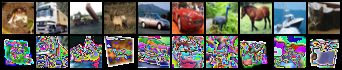

In [ ]:
# plot real and augmented images
from torchvision.utils import make_grid
notransform = transforms.Compose([transforms.ToTensor()])
non_augmented = torchvision.datasets.CIFAR10(root='./data', train=True, transform=notransform)

imgs = torch.stack((*[non_augmented[i][0] for i in range(10)],
                    *[trainset[i][0] for i in range(10)]))
grid = make_grid(imgs, nrow=10)

transforms.ToPILImage()(grid)

Now use it to train the your model

In [ ]:
net = Net().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
train(10, trainloader, net, optimizer, criterion)
#scheduler = MultiStepLR(optimizer, milestones=[3, 8], gamma=0.1)

test(testloader, net)
test_class(testloader, net)

[1,   500] loss: 2.280
[2,   500] loss: 2.048
[3,   500] loss: 1.875
[4,   500] loss: 1.752
[5,   500] loss: 1.694
[6,   500] loss: 1.648
[7,   500] loss: 1.619
[8,   500] loss: 1.577
[9,   500] loss: 1.553
[10,   500] loss: 1.534
Finished Training
Accuracy of the network on the 10000 test images: 49 %
Accuracy for class: plane is 53.3 %
Accuracy for class: car   is 71.8 %
Accuracy for class: bird  is 27.2 %
Accuracy for class: cat   is 17.9 %
Accuracy for class: deer  is 30.4 %
Accuracy for class: dog   is 41.4 %
Accuracy for class: frog  is 67.3 %
Accuracy for class: horse is 67.0 %
Accuracy for class: ship  is 65.3 %
Accuracy for class: truck is 52.3 %


In [25]:
net = Net().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
train(50, trainloader, net, optimizer, criterion)
#scheduler = MultiStepLR(optimizer, milestones=[3, 8], gamma=0.1)

test(testloader, net)
test_class(testloader, net)

[1,   500] loss: 2.147
[2,   500] loss: 1.798
[3,   500] loss: 1.636
[4,   500] loss: 1.561
[5,   500] loss: 1.513
[6,   500] loss: 1.478
[7,   500] loss: 1.438
[8,   500] loss: 1.412
[9,   500] loss: 1.400
[10,   500] loss: 1.373
[11,   500] loss: 1.341
[12,   500] loss: 1.327
[13,   500] loss: 1.305
[14,   500] loss: 1.289
[15,   500] loss: 1.271
[16,   500] loss: 1.251
[17,   500] loss: 1.236
[18,   500] loss: 1.217
[19,   500] loss: 1.202
[20,   500] loss: 1.197
[21,   500] loss: 1.172
[22,   500] loss: 1.166
[23,   500] loss: 1.142
[24,   500] loss: 1.132
[25,   500] loss: 1.124
[26,   500] loss: 1.108
[27,   500] loss: 1.095
[28,   500] loss: 1.087
[29,   500] loss: 1.083
[30,   500] loss: 1.075
[31,   500] loss: 1.056
[32,   500] loss: 1.049
[33,   500] loss: 1.042
[34,   500] loss: 1.027
[35,   500] loss: 1.023
[36,   500] loss: 1.013
[37,   500] loss: 1.005
[38,   500] loss: 0.988
[39,   500] loss: 0.993
[40,   500] loss: 0.983
[41,   500] loss: 0.977
[42,   500] loss: 0.977
[

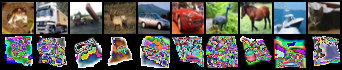

In [ ]:
# Even stronger transform
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.4913998, 0.48215738, 0.44653124), (0.24703224, 0.2434851, 0.26158783)),
                                transforms.RandomPerspective(),
                                transforms.RandomRotation(10),
                                transforms.GaussianBlur(3),
                                transforms.RandomGrayscale(),
                                transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                transforms.ElasticTransform()])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# plot real and augmented images
from torchvision.utils import make_grid
notransform = transforms.Compose([transforms.ToTensor()])
non_augmented = torchvision.datasets.CIFAR10(root='./data', train=True, transform=notransform)

imgs = torch.stack((*[non_augmented[i][0] for i in range(10)],
                    *[trainset[i][0] for i in range(10)]))
grid = make_grid(imgs, nrow=10)

transforms.ToPILImage()(grid)

In [ ]:
net = Net().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
train(10, trainloader, net, optimizer,criterion)

test(testloader, net)
test_class(testloader, net)

[1,   500] loss: 2.298
[2,   500] loss: 2.064
[3,   500] loss: 1.900
[4,   500] loss: 1.805
[5,   500] loss: 1.740
[6,   500] loss: 1.696
[7,   500] loss: 1.666
[8,   500] loss: 1.650
[9,   500] loss: 1.627
[10,   500] loss: 1.605
Finished Training
Accuracy of the network on the 10000 test images: 47 %
Accuracy for class: plane is 53.6 %
Accuracy for class: car   is 78.2 %
Accuracy for class: bird  is 19.9 %
Accuracy for class: cat   is 15.8 %
Accuracy for class: deer  is 37.4 %
Accuracy for class: dog   is 38.1 %
Accuracy for class: frog  is 59.6 %
Accuracy for class: horse is 68.7 %
Accuracy for class: ship  is 51.7 %
Accuracy for class: truck is 47.1 %


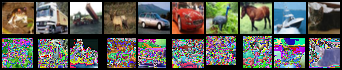

In [26]:
# Standard transform for classification
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.4913998, 0.48215738, 0.44653124), (0.24703224, 0.2434851, 0.26158783)),
                                transforms.RandomCrop(32, padding=4),
                                transforms.RandomHorizontalFlip()])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# plot real and augmented images
from torchvision.utils import make_grid
notransform = transforms.Compose([transforms.ToTensor()])
non_augmented = torchvision.datasets.CIFAR10(root='./data', train=True, transform=notransform)

imgs = torch.stack((*[non_augmented[i][0] for i in range(10)],
                    *[trainset[i][0] for i in range(10)]))
grid = make_grid(imgs, nrow=10)

transforms.ToPILImage()(grid)

In [ ]:
net = Net().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
train(10, trainloader, net, optimizer,criterion)
#scheduler = MultiStepLR(optimizer, milestones=[3, 8], gamma=0.1)

test(testloader, net)
test_class(testloader, net)

[1,   500] loss: 2.300
[2,   500] loss: 2.098
[3,   500] loss: 1.882
[4,   500] loss: 1.743
[5,   500] loss: 1.665
[6,   500] loss: 1.617
[7,   500] loss: 1.561
[8,   500] loss: 1.529
[9,   500] loss: 1.491
[10,   500] loss: 1.445
Finished Training
Accuracy of the network on the 10000 test images: 52 %
Accuracy for class: plane is 50.8 %
Accuracy for class: car   is 64.9 %
Accuracy for class: bird  is 36.7 %
Accuracy for class: cat   is 29.5 %
Accuracy for class: deer  is 38.8 %
Accuracy for class: dog   is 42.3 %
Accuracy for class: frog  is 56.4 %
Accuracy for class: horse is 68.4 %
Accuracy for class: ship  is 75.1 %
Accuracy for class: truck is 62.5 %


In [ ]:
net = Net().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
train(50, trainloader, net, optimizer,criterion)
#scheduler = MultiStepLR(optimizer, milestones=[3, 8], gamma=0.1)

test(testloader, net)
test_class(testloader, net)

[1,   500] loss: 2.287
[2,   500] loss: 2.019
[3,   500] loss: 1.825
[4,   500] loss: 1.713
[5,   500] loss: 1.642
[6,   500] loss: 1.592
[7,   500] loss: 1.545
[8,   500] loss: 1.503
[9,   500] loss: 1.472
[10,   500] loss: 1.432
[11,   500] loss: 1.402
[12,   500] loss: 1.376
[13,   500] loss: 1.348
[14,   500] loss: 1.323
[15,   500] loss: 1.306
[16,   500] loss: 1.287
[17,   500] loss: 1.267
[18,   500] loss: 1.252
[19,   500] loss: 1.237
[20,   500] loss: 1.219
[21,   500] loss: 1.215
[22,   500] loss: 1.209
[23,   500] loss: 1.188
[24,   500] loss: 1.179
[25,   500] loss: 1.165
[26,   500] loss: 1.154
[27,   500] loss: 1.154
[28,   500] loss: 1.132
[29,   500] loss: 1.135
[30,   500] loss: 1.119
[31,   500] loss: 1.117
[32,   500] loss: 1.113
[33,   500] loss: 1.097
[34,   500] loss: 1.086
[35,   500] loss: 1.096
[36,   500] loss: 1.076
[37,   500] loss: 1.074
[38,   500] loss: 1.060
[39,   500] loss: 1.058
[40,   500] loss: 1.049
[41,   500] loss: 1.045
[42,   500] loss: 1.036
[

## Exercise 3
A) Try to change the network architecture (e.g. use all linear layers) or network hyperparameters (e.g. dimensions of the CNN kernel, stride, padding).

B) Try also to compare performance of your model with performance of pre-defined network architecture.
There are a lot of pre-defined network architectures (e.g. ResNet, VGG, AlexNet, ...).

Some example can be found in https://pytorch.org/vision/0.9/models.html.

Specific CIFAR10 architectures are also in this public repository https://github.com/kuangliu/pytorch-cifar.

In [14]:
# Exercise 3A

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4913998, 0.48215738, 0.44653124), (0.24703224, 0.2434851, 0.26158783))])

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Network with all linear layers
class FC_Net(nn.Module):
    def __init__(self, input_size = 3072, output_size = 10, layers = [32, 32]):
        super().__init__()

        self.first_layer = nn.Linear(input_size, layers[0])
        self.inner_layers = nn.ModuleList([nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        self.last_layer = nn.Linear(layers[-1], output_size)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.first_layer(x))
        for layer in self.inner_layers:
            x = F.relu(layer(x))
        x = self.last_layer(x)
        output = F.log_softmax(x, dim=1)
        return output

def train(epochs, trainloader, optimizer, net, criterion, scheduler=None):
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            epoch_loss = []
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_loss.append(loss.item())
            #if (i + 1) % 500 == 0:    # print every 5000 mini-batches
             #   print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 500:.3f}')
              #  running_loss = 0.0
        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(np.mean(epoch_loss))
            else:
                scheduler.step()
        print(f"Epoch mean loss: {np.mean(epoch_loss):.3f}")
    print('Finished Training')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
model1 = FC_Net(layers = [32, 64 ,128]).to(device)
optimizer = optim.SGD(model1.parameters(), lr=0.001, momentum=0.9)
train(10, trainloader, optimizer, model1, criterion)
test(testloader, model1)
test_class(testloader, model1)

#model2 = FC_Net(layers = [20384, 20384]).to(device) # few large layers -> overfitting, too much parameters
#optimizer = optim.SGD(model2.parameters(), lr=0.001, momentum=0.9)
#train(10, trainloader, optimizer, model2, criterion)
#test(testloader, model2)
#test_class(testloader, model2)

model2 = FC_Net(layers = [32, 64, 128]).to(device)
optimizer = optim.SGD(model1.parameters(), lr=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=0)
train(10, trainloader, optimizer, model1, criterion, scheduler)
test(testloader, model1)
test_class(testloader, model1)

model3 = FC_Net(layers = [32, 32, 32, 32, 32, 32, 32, 32, 32]).to(device) # vanishing gradient
optimizer = optim.SGD(model3.parameters(), lr=0.001, momentum=0.9)
train(10, trainloader, optimizer, model3, criterion)
test(testloader, model3)
test_class(testloader, model3)

Epoch mean loss: 1.766
Epoch mean loss: 2.043
Epoch mean loss: 1.708
Epoch mean loss: 1.577
Epoch mean loss: 1.566
Epoch mean loss: 1.524
Epoch mean loss: 1.390
Epoch mean loss: 1.447
Epoch mean loss: 1.420
Epoch mean loss: 1.053
Finished Training
Accuracy of the network on the 10000 test images: 48 %
Accuracy for class: plane is 45.4 %
Accuracy for class: car   is 56.3 %
Accuracy for class: bird  is 34.5 %
Accuracy for class: cat   is 37.9 %
Accuracy for class: deer  is 37.0 %
Accuracy for class: dog   is 30.4 %
Accuracy for class: frog  is 60.6 %
Accuracy for class: horse is 54.0 %
Accuracy for class: ship  is 69.9 %
Accuracy for class: truck is 55.1 %
Epoch mean loss: 1.469
Epoch mean loss: 0.995
Epoch mean loss: 1.323
Epoch mean loss: 1.430
Epoch mean loss: 1.331
Epoch mean loss: 1.114
Epoch mean loss: 1.232
Epoch mean loss: 1.285
Epoch mean loss: 1.572
Epoch mean loss: 1.397
Finished Training
Accuracy of the network on the 10000 test images: 50 %
Accuracy for class: plane is 56.6 

In [ ]:
# Changing CNN hyperparameters:

class Net(nn.Module):
    def __init__(self, kernel_size=5, stride=1, padding=0):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size, stride, padding)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size, stride, padding)
        if kernel_size == 5:
            if padding == 2:
                self.fc1 = nn.Linear(1024, 120)
            elif stride == 2:
                self.fc1 = nn.Linear(16, 120)
            else:
                self.fc1 = nn.Linear(16 * 5 * 5, 120)
        elif kernel_size == 3:
            self.fc1 = nn.Linear(576, 120)
        elif kernel_size == 1:
            self.fc1 = nn.Linear(1024, 120)
        else: # kernel_size == 7
            if padding == 3:
                self.fc1 = nn.Linear(1024, 120)
            else:
                self.fc1 = nn.Linear(144, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
# Changing kernel dimension of the conv layers
model1 = Net(kernel_size=3).to(device)
optimizer = optim.SGD(model1.parameters(), lr=0.001, momentum=0.9)
train(10, trainloader, optimizer, model1, criterion)
test(testloader, model1)
test_class(testloader, model1)

model2 = Net(kernel_size=1).to(device)
optimizer = optim.SGD(model2.parameters(), lr=0.001, momentum=0.9)
train(10, trainloader, optimizer, model2, criterion)
test(testloader, model2)
test_class(testloader, model2)

model3 = Net(kernel_size=7).to(device)
optimizer = optim.SGD(model3.parameters(), lr=0.001, momentum=0.9)
train(10, trainloader, optimizer, model3, criterion)
test(testloader, model3)
test_class(testloader, model3)

Epoch mean loss: 2.140
Epoch mean loss: 1.743
Epoch mean loss: 1.971
Epoch mean loss: 1.381
Epoch mean loss: 1.430
Epoch mean loss: 1.198
Epoch mean loss: 1.211
Epoch mean loss: 0.954
Epoch mean loss: 1.311
Epoch mean loss: 1.323
Finished Training
Accuracy of the network on the 10000 test images: 55 %
Accuracy for class: plane is 64.9 %
Accuracy for class: car   is 62.5 %
Accuracy for class: bird  is 40.8 %
Accuracy for class: cat   is 42.4 %
Accuracy for class: deer  is 41.2 %
Accuracy for class: dog   is 43.4 %
Accuracy for class: frog  is 71.1 %
Accuracy for class: horse is 55.8 %
Accuracy for class: ship  is 73.8 %
Accuracy for class: truck is 61.3 %
Epoch mean loss: 2.278
Epoch mean loss: 2.117
Epoch mean loss: 1.720
Epoch mean loss: 1.637
Epoch mean loss: 1.580
Epoch mean loss: 1.499
Epoch mean loss: 1.356
Epoch mean loss: 1.296
Epoch mean loss: 1.583
Epoch mean loss: 1.352
Finished Training
Accuracy of the network on the 10000 test images: 48 %
Accuracy for class: plane is 57.0 

In [ ]:
# Changing padding of the conv layers, based on the previous models to see improvements with increased kernel size
model1 = Net(kernel_size=5, padding=2).to(device)
optimizer = optim.SGD(model1.parameters(), lr=0.001, momentum=0.9)
train(10, trainloader, optimizer, model1, criterion)
test(testloader, model1)
test_class(testloader, model1)

model2 = Net(kernel_size=7, padding=3).to(device)
optimizer = optim.SGD(model2.parameters(), lr=0.001, momentum=0.9)
train(10, trainloader, optimizer, model2, criterion)
test(testloader, model2)
test_class(testloader, model2)

Epoch mean loss: 2.174
Epoch mean loss: 1.911
Epoch mean loss: 1.664
Epoch mean loss: 1.447
Epoch mean loss: 1.354
Epoch mean loss: 1.410
Epoch mean loss: 1.361
Epoch mean loss: 1.650
Epoch mean loss: 0.894
Epoch mean loss: 1.225
Finished Training
Accuracy of the network on the 10000 test images: 62 %
Accuracy for class: plane is 71.7 %
Accuracy for class: car   is 77.9 %
Accuracy for class: bird  is 55.2 %
Accuracy for class: cat   is 33.7 %
Accuracy for class: deer  is 52.2 %
Accuracy for class: dog   is 59.3 %
Accuracy for class: frog  is 69.4 %
Accuracy for class: horse is 73.0 %
Accuracy for class: ship  is 72.4 %
Accuracy for class: truck is 62.3 %
Epoch mean loss: 1.786
Epoch mean loss: 1.392
Epoch mean loss: 1.535
Epoch mean loss: 1.452
Epoch mean loss: 1.999
Epoch mean loss: 1.358
Epoch mean loss: 0.851
Epoch mean loss: 0.935
Epoch mean loss: 1.424
Epoch mean loss: 1.048
Finished Training
Accuracy of the network on the 10000 test images: 59 %
Accuracy for class: plane is 55.8 

In [ ]:
# Added scheduler
model1 = Net(kernel_size=5, padding=2).to(device)
optimizer = optim.SGD(model1.parameters(), lr=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=0)
train(10, trainloader, optimizer, model1, criterion, scheduler)
test(testloader, model1)
test_class(testloader, model1)

model2 = Net(kernel_size=7, padding=3).to(device)
optimizer = optim.SGD(model2.parameters(), lr=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=0)
train(10, trainloader, optimizer, model2, criterion)
test(testloader, model2)
test_class(testloader, model2)

Epoch mean loss: 1.870
Epoch mean loss: 1.407
Epoch mean loss: 1.563
Epoch mean loss: 1.432
Epoch mean loss: 1.093
Epoch mean loss: 1.284
Epoch mean loss: 1.273
Epoch mean loss: 1.817
Epoch mean loss: 1.474
Epoch mean loss: 1.492
Finished Training
Accuracy of the network on the 10000 test images: 49 %
Accuracy for class: plane is 54.8 %
Accuracy for class: car   is 64.4 %
Accuracy for class: bird  is 26.4 %
Accuracy for class: cat   is 33.0 %
Accuracy for class: deer  is 33.8 %
Accuracy for class: dog   is 41.4 %
Accuracy for class: frog  is 62.6 %
Accuracy for class: horse is 57.6 %
Accuracy for class: ship  is 61.1 %
Accuracy for class: truck is 55.9 %
Epoch mean loss: 2.034
Epoch mean loss: 1.860
Epoch mean loss: 1.731
Epoch mean loss: 0.981
Epoch mean loss: 1.105
Epoch mean loss: 0.998
Epoch mean loss: 1.079
Epoch mean loss: 1.036
Epoch mean loss: 0.752
Epoch mean loss: 0.697
Finished Training
Accuracy of the network on the 10000 test images: 61 %
Accuracy for class: plane is 70.7 

In [ ]:
# Added scheduler, higher starting lr
model1 = Net(kernel_size=5, padding=2).to(device)
optimizer = optim.SGD(model1.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=0)
train(10, trainloader, optimizer, model1, criterion, scheduler)
test(testloader, model1)
test_class(testloader, model1)

model2 = Net(kernel_size=7, padding=3).to(device)
optimizer = optim.SGD(model2.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=0)
train(10, trainloader, optimizer, model2, criterion)
test(testloader, model2)
test_class(testloader, model2)

Epoch mean loss: 1.211
Epoch mean loss: 0.799
Epoch mean loss: 0.855
Epoch mean loss: 1.052
Epoch mean loss: 1.350
Epoch mean loss: 0.891
Epoch mean loss: 0.655
Epoch mean loss: 0.782
Epoch mean loss: 0.484
Epoch mean loss: 0.568
Finished Training
Accuracy of the network on the 10000 test images: 66 %
Accuracy for class: plane is 70.9 %
Accuracy for class: car   is 78.3 %
Accuracy for class: bird  is 52.0 %
Accuracy for class: cat   is 46.3 %
Accuracy for class: deer  is 59.5 %
Accuracy for class: dog   is 53.1 %
Accuracy for class: frog  is 76.4 %
Accuracy for class: horse is 73.2 %
Accuracy for class: ship  is 80.2 %
Accuracy for class: truck is 74.4 %
Epoch mean loss: 1.289
Epoch mean loss: 2.453
Epoch mean loss: 1.343
Epoch mean loss: 0.896
Epoch mean loss: 0.973
Epoch mean loss: 0.916
Epoch mean loss: 0.553
Epoch mean loss: 0.760
Epoch mean loss: 1.322
Epoch mean loss: 0.199
Finished Training
Accuracy of the network on the 10000 test images: 63 %
Accuracy for class: plane is 73.3 

In [ ]:
# Changing stride of the conv layers
model1 = Net(stride=2).to(device)
optimizer = optim.SGD(model1.parameters(), lr=0.001, momentum=0.9)
train(10, trainloader, optimizer, model1, criterion)
test(testloader, model1)
test_class(testloader, model1)

# Stride more than 2 comprimes the output too much
# Added scheduler
model2 = Net(stride=2).to(device)
optimizer = optim.SGD(model2.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=0)
train(10, trainloader, optimizer, model2, criterion)
test(testloader, model2)
test_class(testloader, model2)

model3 = Net(stride=2).to(device)
optimizer = optim.SGD(model3.parameters(), lr=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=0)
train(10, trainloader, optimizer, model3, criterion)
test(testloader, model3)
test_class(testloader, model3)

Epoch mean loss: 2.219
Epoch mean loss: 1.831
Epoch mean loss: 1.514
Epoch mean loss: 1.651
Epoch mean loss: 1.660
Epoch mean loss: 1.106
Epoch mean loss: 1.706
Epoch mean loss: 1.438
Epoch mean loss: 1.499
Epoch mean loss: 1.786
Finished Training
Accuracy of the network on the 10000 test images: 46 %
Accuracy for class: plane is 53.7 %
Accuracy for class: car   is 72.9 %
Accuracy for class: bird  is 32.3 %
Accuracy for class: cat   is 25.6 %
Accuracy for class: deer  is 29.2 %
Accuracy for class: dog   is 42.0 %
Accuracy for class: frog  is 66.2 %
Accuracy for class: horse is 57.3 %
Accuracy for class: ship  is 52.1 %
Accuracy for class: truck is 38.4 %
Epoch mean loss: 1.207
Epoch mean loss: 1.101
Epoch mean loss: 1.295
Epoch mean loss: 1.631
Epoch mean loss: 1.543
Epoch mean loss: 1.346
Epoch mean loss: 2.144
Epoch mean loss: 1.351
Epoch mean loss: 1.563
Epoch mean loss: 0.983
Finished Training
Accuracy of the network on the 10000 test images: 52 %
Accuracy for class: plane is 53.9 

In [28]:
# Best model
net = Net(kernel_size=5, padding=2).to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
train(30, trainloader, net, optimizer, criterion)
test(testloader, net)
test_class(testloader, net)

[1,   500] loss: 2.106
[2,   500] loss: 1.756
[3,   500] loss: 1.621
[4,   500] loss: 1.531
[5,   500] loss: 1.471
[6,   500] loss: 1.427
[7,   500] loss: 1.380
[8,   500] loss: 1.334
[9,   500] loss: 1.305
[10,   500] loss: 1.270
[11,   500] loss: 1.243
[12,   500] loss: 1.209
[13,   500] loss: 1.184
[14,   500] loss: 1.166
[15,   500] loss: 1.146
[16,   500] loss: 1.115
[17,   500] loss: 1.093
[18,   500] loss: 1.076
[19,   500] loss: 1.069
[20,   500] loss: 1.040
[21,   500] loss: 1.031
[22,   500] loss: 1.016
[23,   500] loss: 0.999
[24,   500] loss: 0.984
[25,   500] loss: 0.975
[26,   500] loss: 0.958
[27,   500] loss: 0.946
[28,   500] loss: 0.933
[29,   500] loss: 0.930
[30,   500] loss: 0.918
Finished Training
Accuracy of the network on the 10000 test images: 68 %
Accuracy for class: plane is 77.3 %
Accuracy for class: car   is 77.4 %
Accuracy for class: bird  is 57.0 %
Accuracy for class: cat   is 50.6 %
Accuracy for class: deer  is 66.4 %
Accuracy for class: dog   is 60.3 %


In [ ]:
# Best Model with scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau

net = Net(kernel_size=5, padding=2).to(device)
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=0)

train(30, trainloader, net, optimizer, criterion, scheduler)
test(testloader, net)
test_class(testloader, net)

[1,   500] loss: 1.895
[2,   500] loss: 1.469
[3,   500] loss: 1.315
[4,   500] loss: 1.210
[5,   500] loss: 1.165
[6,   500] loss: 1.119
[7,   500] loss: 1.092
[8,   500] loss: 1.040
[9,   500] loss: 1.033
[10,   500] loss: 1.005
[11,   500] loss: 1.008
[12,   500] loss: 0.988
[13,   500] loss: 0.970
[14,   500] loss: 0.954
[15,   500] loss: 0.947
[16,   500] loss: 0.950
[17,   500] loss: 0.936
[18,   500] loss: 0.931
[19,   500] loss: 0.832
[20,   500] loss: 0.797
[21,   500] loss: 0.798
[22,   500] loss: 0.789
[23,   500] loss: 0.781
[24,   500] loss: 0.777
[25,   500] loss: 0.762
[26,   500] loss: 0.762
[27,   500] loss: 0.761
[28,   500] loss: 0.756
[29,   500] loss: 0.760
[30,   500] loss: 0.760
Finished Training
Accuracy of the network on the 10000 test images: 73 %
Accuracy for class: plane is 80.5 %
Accuracy for class: car   is 84.9 %
Accuracy for class: bird  is 61.7 %
Accuracy for class: cat   is 52.4 %
Accuracy for class: deer  is 70.6 %
Accuracy for class: dog   is 62.4 %


In [21]:
# Removing Max Pooling
# Changing CNN hyperparameters:

class Net(nn.Module):
    def __init__(self, kernel_size=5, stride=1, padding=2):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size, stride, padding)
        self.conv2 = nn.Conv2d(6, 16, kernel_size, stride, padding)
        if kernel_size == 5:
            if padding == 2:
                self.fc1 = nn.Linear(16384, 120)
            elif stride == 2:
                self.fc1 = nn.Linear(16, 120)
            else:
                self.fc1 = nn.Linear(16 * 5 * 5, 120)
        elif kernel_size == 3:
            self.fc1 = nn.Linear(576, 120)
        elif kernel_size == 1:
            self.fc1 = nn.Linear(1024, 120)
        else: # kernel_size == 7
            if padding == 3:
                self.fc1 = nn.Linear(1024, 120)
            else:
                self.fc1 = nn.Linear(144, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [22]:
# Best Model with scheduler and no pooling
from torch.optim.lr_scheduler import ReduceLROnPlateau

net = Net().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=0)

train(30, trainloader, optimizer, net, criterion, scheduler)
test(testloader, net)
test_class(testloader, net)

Epoch mean loss: 1.252
Epoch mean loss: 1.149
Epoch mean loss: 1.856
Epoch mean loss: 1.570
Epoch mean loss: 1.001
Epoch mean loss: 1.261
Epoch mean loss: 1.287
Epoch mean loss: 1.211
Epoch mean loss: 0.970
Epoch mean loss: 1.154
Epoch mean loss: 1.355
Epoch mean loss: 0.681
Epoch mean loss: 1.043
Epoch mean loss: 1.064
Epoch mean loss: 0.776
Epoch mean loss: 0.722
Epoch mean loss: 0.843
Epoch mean loss: 1.310
Epoch mean loss: 1.135
Epoch mean loss: 1.214
Epoch mean loss: 1.358
Epoch mean loss: 1.497
Epoch mean loss: 0.938
Epoch mean loss: 1.205
Epoch mean loss: 0.982
Epoch mean loss: 0.753
Epoch mean loss: 1.069
Epoch mean loss: 0.662
Epoch mean loss: 0.922
Epoch mean loss: 0.701
Finished Training
Accuracy of the network on the 10000 test images: 63 %
Accuracy for class: plane is 68.9 %
Accuracy for class: car   is 74.5 %
Accuracy for class: bird  is 49.4 %
Accuracy for class: cat   is 43.7 %
Accuracy for class: deer  is 53.0 %
Accuracy for class: dog   is 50.7 %
Accuracy for class: f

In [27]:
# Exercise 3B

import torchvision.models as models
alexnet = models.alexnet()
resnet18 = models.resnet18()
vgg16 = models.vgg16()

def train(epochs, trainloader, net, optimizer, criterion, scheduler=None):
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if (i + 1) % 500 == 0:    # print every 5000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 500:.3f}')
                running_loss = 0.0
        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(running_loss)
            else:
                scheduler.step()
    print('Finished Training')

In [ ]:
alexnet.fc = nn.Linear(512, 10)
alexnet.to(device)
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.4913998, 0.48215738, 0.44653124), (0.24703224, 0.2434851, 0.26158783)),
                                transforms.Resize((469, 387))]) # Resized like ImageNet, otherwise there was an error with the predefined model
                                                                # because there was a global pooling that made the images 0x0
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


optimizer = optim.SGD(alexnet.parameters(), lr=0.001, momentum=0.9)
train(30, trainloader, alexnet, optimizer, criterion)
test(testloader, alexnet)
test_class(testloader, alexnet)

Files already downloaded and verified
Accuracy of the network on the 10000 test images: 77 %
Accuracy for class: plane is 81.2 %
Accuracy for class: car   is 90.5 %
Accuracy for class: bird  is 73.6 %
Accuracy for class: cat   is 65.7 %
Accuracy for class: deer  is 72.5 %
Accuracy for class: dog   is 61.5 %
Accuracy for class: frog  is 82.1 %
Accuracy for class: horse is 81.8 %
Accuracy for class: ship  is 87.5 %
Accuracy for class: truck is 79.7 %


In [ ]:
resnet18.fc = nn.Linear(512, 10)
resnet18.to(device)

optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)
train(30, trainloader, resnet18, optimizer, criterion)
test(testloader, resnet18)
test_class(testloader, resnet18)

[1,   500] loss: 1.701
[2,   500] loss: 1.262
[3,   500] loss: 1.048
[4,   500] loss: 0.880
[5,   500] loss: 0.736
[6,   500] loss: 0.603
[7,   500] loss: 0.482
[8,   500] loss: 0.379
[9,   500] loss: 0.293
[10,   500] loss: 0.241
[11,   500] loss: 0.208
[12,   500] loss: 0.172
[13,   500] loss: 0.129
[14,   500] loss: 0.117
[15,   500] loss: 0.115
[16,   500] loss: 0.089
[17,   500] loss: 0.083
[18,   500] loss: 0.065
[19,   500] loss: 0.059
[20,   500] loss: 0.051
[21,   500] loss: 0.062
[22,   500] loss: 0.056
[23,   500] loss: 0.040
[24,   500] loss: 0.033
[25,   500] loss: 0.035
[26,   500] loss: 0.033
[27,   500] loss: 0.031
[28,   500] loss: 0.029
[29,   500] loss: 0.025
[30,   500] loss: 0.031
Finished Training
Accuracy of the network on the 10000 test images: 66 %
Accuracy for class: plane is 71.3 %
Accuracy for class: car   is 78.0 %
Accuracy for class: bird  is 55.4 %
Accuracy for class: cat   is 46.7 %
Accuracy for class: deer  is 61.1 %
Accuracy for class: dog   is 50.9 %


In [ ]:
resnet18 = models.resnet18()
resnet18.fc = nn.Linear(512, 10)
resnet18.to(device)

optimizer = optim.SGD(resnet18.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=0)
train(30, trainloader, resnet18, optimizer, criterion, scheduler)
test(testloader, resnet18)
test_class(testloader, resnet18)

[1,   500] loss: 1.677
[2,   500] loss: 1.110
[3,   500] loss: 0.880
[4,   500] loss: 0.724
[5,   500] loss: 0.600
[6,   500] loss: 0.496
[7,   500] loss: 0.406
[8,   500] loss: 0.325
[9,   500] loss: 0.260
[10,   500] loss: 0.212
[11,   500] loss: 0.176
[12,   500] loss: 0.141
[13,   500] loss: 0.128
[14,   500] loss: 0.105
[15,   500] loss: 0.087
[16,   500] loss: 0.072
[17,   500] loss: 0.073
[18,   500] loss: 0.058
[19,   500] loss: 0.064
[20,   500] loss: 0.043
[21,   500] loss: 0.046
[22,   500] loss: 0.044
[23,   500] loss: 0.020
[24,   500] loss: 0.006
[25,   500] loss: 0.004
[26,   500] loss: 0.003
[27,   500] loss: 0.003
[28,   500] loss: 0.002
[29,   500] loss: 0.002
[30,   500] loss: 0.002
Finished Training
Accuracy of the network on the 10000 test images: 76 %
Accuracy for class: plane is 80.9 %
Accuracy for class: car   is 85.9 %
Accuracy for class: bird  is 67.2 %
Accuracy for class: cat   is 57.0 %
Accuracy for class: deer  is 74.9 %
Accuracy for class: dog   is 66.1 %


In [ ]:
vgg16.fc = nn.Linear(512, 10)
vgg16.to(device)

optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
train(30, trainloader, vgg16, optimizer, criterion)
test(testloader, vgg16)
test_class(testloader, vgg16)

[1,   500] loss: 2.680
[2,   500] loss: 1.802
[3,   500] loss: 1.462
[4,   500] loss: 1.244
[5,   500] loss: 1.069
[6,   500] loss: 0.938
[7,   500] loss: 0.826
[8,   500] loss: 0.711
[9,   500] loss: 0.615
[10,   500] loss: 0.533
[11,   500] loss: 0.462
[12,   500] loss: 0.386
[13,   500] loss: 0.320
[14,   500] loss: 0.274
[15,   500] loss: 0.233
[16,   500] loss: 0.184
[17,   500] loss: 0.155
[18,   500] loss: 0.135
[19,   500] loss: 0.110
[20,   500] loss: 0.099
[21,   500] loss: 0.081
[22,   500] loss: 0.085
[23,   500] loss: 0.061
[24,   500] loss: 0.056
[25,   500] loss: 0.054
[26,   500] loss: 0.044
[27,   500] loss: 0.041
[28,   500] loss: 0.039
[29,   500] loss: 0.036
[30,   500] loss: 0.025
Finished Training
Accuracy of the network on the 10000 test images: 77 %
Accuracy for class: plane is 82.8 %
Accuracy for class: car   is 89.5 %
Accuracy for class: bird  is 77.2 %
Accuracy for class: cat   is 59.2 %
Accuracy for class: deer  is 74.3 %
Accuracy for class: dog   is 58.5 %
